In [1226]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling3D, GlobalMaxPooling3D
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, AveragePooling3D
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import Model
import keras
from sklearn.model_selection import train_test_split
import numpy as np
import collections

In [769]:
import istarmap
import h5py
from multiprocessing import Pool
from itertools import repeat
import prody as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
from tqdm import tqdm
import glob


# Functions and classes

In [770]:
def define_vocabulary(atoms):
    elements = set([atom.getElement() for atom in atoms])
    return  elements




In [1227]:
def count_elements(atoms):
    elements = [atom.getElement() for atom in atoms]
    return   collections.Counter(elements)

In [771]:
class Grid(object):

    def __init__(self, center, side, resolution=None):
        self.center = center
        self.side = side
        self.resolution = resolution
        self.vertexes = self._calculate_vertexes()
    def _calculate_vertexes(self):
        center = self.center
        side = self.side

        vertexes = []
        v1 = center + [-side/2, -side/2, -side/2]
        v2 = center + [side/2, -side/2, -side/2]
        v3 = center + [-side/2, -side/2, side/2]
        v4 = center + [-side/2, side/2, -side/2]
        v5 = center + [side/2, side/2, -side/2]
        v6 = center + [side/2, -side/2, side/2]
        v7 = center + [-side/2, side/2, side/2]
        v8 = center + [side/2, side/2, side/2]
        vertexes.extend([v1, v2, v3, v4, v5, v6, v7, v8])
        return vertexes
    
    def calculate_pixels(self):
        print("Calculating pixels...")
        rear_back_pixel_center = self.rear_back_pixel_center = self.vertexes[6]  + np.array((self.resolution/2, -self.resolution/2, -self.resolution/2))
        self.n_pixels = n_pixels =  int(self.side / self.resolution)
        current_pixel_center = rear_back_pixel_center; self.pixels = np.empty((n_pixels, n_pixels, n_pixels),  dtype=object)
        for z in range(n_pixels):
            for j in range(n_pixels):
                for  i in range(n_pixels):
                    self.pixels[i][j][z] = Grid(current_pixel_center, self.resolution)
                    current_pixel_center = current_pixel_center + np.array((self.resolution, 0, 0))
                current_pixel_center = rear_back_pixel_center + np.array((0, (j+1)*-self.resolution, (z+1)*-self.resolution))



    def is_point_inside(self, point):
        dist = np.linalg.norm(self.center-point)
        dist_center_diagonal = np.linalg.norm(self.center-self.vertexes[0])
        if dist < dist_center_diagonal:
            return True
        else:
            return False

    def plot(self):
        fig = plt.figure()
        ax = Axes3D(fig)
        for vertex in self.vertexes:
            vx, vy,vz = vertex.tolist()
            ax.scatter(vx, vy, vz)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        return fig.show()


In [772]:
def retrieve_vocabulary(pdbs):

    vocabulary_elements=[]; features=[]
    for pdb in tqdm(pdbs):
        i = 1
        try:
            while True:
                atoms = pd.parsePDB(pdb, model=i)
                i += 1
                elements = define_vocabulary(atoms)
                for element in elements:
                    if element not in vocabulary_elements:
                        vocabulary_elements.append(element)
        except pd.proteins.pdbfile.PDBParseError:
            continue
    vocabulary_elements = {res:i for i, res in enumerate(vocabulary_elements)}
    features = len(vocabulary_elements)
    return  vocabulary_elements, features




In [778]:
def extract_cnn_input(pdb ,residue):

    info = []; i = 1
    try:
        while True:

            print("Load trajectory")
            atoms = pd.parsePDB(pdb, model=i)
            print(atoms)
            ligand = atoms.select("resname {}".format(residue))

            for atom in ligand:
                #assert atom.getResname() == residue, "Something wrong with ligand extraction"
                pass


            print("Find CM of the ligand")
            cm = np.array([0.994,  16.908, -60.583])
            side = 20
            print("CM", cm)

            print("Build grid")
            grid2 = Grid(cm, side, 1)
            grid2.calculate_pixels()

            print("Checking created grid")
            inside = [grid2.is_point_inside for pixel in grid2.pixels]
            assert  all(inside), "Some point of the grid out of the box check code!"

            print("Filling grid with atom info")
            atoms_per_pixel = fill_grid_with_atoms(grid2, atoms, residue, vocabulary_elements, features)
            i += 1
            info.append(atoms_per_pixel)

    except pd.proteins.pdbfile.PDBParseError:
        print(i)
        return [info, pdb]

In [779]:
def fill_grid_with_atoms(grid2, atoms, residue, vocabulary_elements, features):
    atoms_per_pixel = np.zeros((grid2.n_pixels, grid2.n_pixels, grid2.n_pixels, features),  dtype=int)

    atoms_selection = atoms.select("within 20 of resname {}".format(residue))
    count = 0
    for  atom in atoms:
        
        atom_type = atom.getName()
        residue = atom.getResname()
        element = atom.getElement()
        coords = atom.getCoords()
        
        assert grid2.is_point_inside(coords), coords

        idxs = np.array([int(abs((x/grid2.resolution))) for x in np.array(np.array(coords) - np.array(grid2.rear_back_pixel_center))])
        #If atom is outside grid
        try:
            atoms_per_pixel[idxs[0]][idxs[1]][idxs[2]]
        except IndexError:
            continue
 
      

        pixel = atoms_per_pixel[idxs[0]][idxs[1]][idxs[2]].copy()
            
        try:
            pixel[vocabulary_elements[element]] += 1
        except TypeError:
            pixel[vocabulary_elements[element]] = 1

        atoms_per_pixel[idxs[0], idxs[1], idxs[2]] = pixel

    return atoms_per_pixel

# Extract features

In [780]:
cpus = 5
pdbs = glob.glob("structs-*.pdb")
residue = "UNK"
#Create vocabulary
vocabulary_elements, features = retrieve_vocabulary(pdbs)
print(features)

#Create Features
with Pool(cpus) as pool:
    result = list(tqdm(pool.istarmap(extract_cnn_input, zip(pdbs, repeat(residue))), total=len(pdbs)))











  0%|          | 0/1223 [00:00<?, ?it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 44 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 49 atoms and 1 coor

@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.










 11%|█▏        | 139/1223 [00:00<00:03, 341.19it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms

@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.










 23%|██▎       | 283/1223 [00:00<00:02, 350.05it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 67 atoms

@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 78 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 45 atoms and 1 coordinate set(s) were parsed in 0.00s.










 35%|███▍      | 422/1223 [00:01<00:02, 341.10it/s]@> 49 atoms

@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 41 atoms an

@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 61 atoms an

@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 65 atoms an

@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.










 78%|███████▊  | 953/1223 [00:02<00:00, 352.68it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 86 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 86 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 89 atoms

@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.










 90%|████████▉ | 1095/1223 [00:03<00:00, 344.18it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atom

@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
100%|██████████| 1223/1223 [00:03<00:00, 345.41it/s]

9


Load trajectory


  0%|          | 0/1223 [00:00<?, ?it/s]

Load trajectory
Load trajectory
Load trajectory
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 44 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-981
AtomGroup structs-995


@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-759
Find CM of the ligand
Find CM of the ligand
Find CM of the ligand
AtomGroup structs-765
AtomGroup structs-771
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Find CM of the ligand
Find CM of the ligand
Build grid
Build grid
Build grid
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Calculating pixels...
Build grid
Calculating pixels...
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-942
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


  0%|          | 1/1223 [00:01<24:50,  1.22s/it]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-956
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


Build grid
Calculating pixels...
AtomGroup structs-1071
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-83
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-229
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
2
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1065
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












  0%|          | 6/1223 [00:14<33:14,  1.64s/it]@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-97
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-201
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 65 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-567
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Find CM of the ligand












  1%|          | 7/1223 [00:14<23:57,  1.18s/it]

Load trajectory


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-573
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












  1%|          | 11/1223 [00:15<18:02,  1.12it/s]

Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1059
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-215
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-40
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory












  1%|          | 12/1223 [00:15<13:19,  1.52it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-54
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 52 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-598
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












  1%|▏         | 16/1223 [00:16<10:24,  1.93it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-68
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-349
Find CM of the ligand


@> 92 atoms and 1 coordinate set(s) were parsed in 0.01s.


CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
AtomGroup structs-1105
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-1111
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


  2%|▏         | 19/1223 [00:16<07:29,  2.68it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-375
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












  2%|▏         | 21/1223 [00:16<07:24,  2.71it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-413
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 96 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-1139
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-407
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-361
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-639
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Checking created grid
2
Filling grid with atom info
Load trajectory
2
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 87 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-611
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


  2%|▏         | 26/1223 [00:17<06:09,  3.24it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-177
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-163
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-836
AtomGroup structs-605
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2


Load trajectory


  3%|▎         | 31/1223 [00:18<05:10,  3.84it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-188
Find CM of the ligand


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
CM [  0.994  16.908 -60.583]
AtomGroup structs-822
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid


@> 54 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-823
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Calculating pixels...


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-837
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-189
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












  3%|▎         | 36/1223 [00:19<04:25,  4.47it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-162
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-604
Find CM of the ligand


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
Build grid
AtomGroup structs-610
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-638
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
AtomGroup structs-176
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Checking created grid
2
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory












  3%|▎         | 41/1223 [00:20<04:00,  4.92it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-406
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-360


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1138
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Calculating pixels...
Load trajectory
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-374
Find CM of the ligand


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
AtomGroup structs-412
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Checking created grid
Load trajectory
Filling grid with atom info
Load trajectory
2
2
Filling grid with atom info
Load trajectory
2


Load trajectory


  4%|▍         | 46/1223 [00:20<03:37,  5.42it/s]@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1110
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-348
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1104
Find CM of the ligand
Load trajectory


Load trajectory


  4%|▍         | 48/1223 [00:20<02:52,  6.82it/s]

CM [  0.994  16.908 -60.583]


@> 69 atoms and 1 coordinate set(s) were parsed in 0.01s.


Build grid
Calculating pixels...
AtomGroup structs-69
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 59 atoms and 1 coordinate set(s) were parsed in 0.03s.


AtomGroup structs-55
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-41
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


  4%|▍         | 51/1223 [00:21<03:14,  6.01it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-599
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-214
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-572
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-1058
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-200
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












  5%|▍         | 56/1223 [00:22<03:02,  6.40it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-566
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-96
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-228
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1064
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












  5%|▍         | 61/1223 [00:22<02:50,  6.80it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-82
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-1070
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-957
Find CM of the ligand


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-943
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


  5%|▌         | 64/1223 [00:22<02:13,  8.70it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-770
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-764
AtomGroup structs-994
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
CM [  0.994  16.908 -60.583]
Load trajectory












  5%|▌         | 66/1223 [00:23<03:17,  5.86it/s]

Build grid


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-980
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-758
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-996
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
2


Load trajectory


  6%|▌         | 71/1223 [00:24<03:01,  6.36it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-982
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-766


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
AtomGroup structs-772
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-941
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-955
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Load trajectory












  6%|▌         | 76/1223 [00:24<02:58,  6.44it/s]

Load trajectory


Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-969


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
AtomGroup structs-1066
CM [  0.994  16.908 -60.583]
Find CM of the ligand
Build grid
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...


@> 55 atoms and 1 coordinate set(s) were parsed in 0.05s.


AtomGroup structs-799
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-94
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-558
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1072


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
AtomGroup structs-80
CM [  0.994  16.908 -60.583]
Find CM of the ligand
Build grid
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...


Load trajectory


  7%|▋         | 81/1223 [00:25<02:51,  6.66it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-216
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-570
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-564
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Load trajectory
Filling grid with atom info
Checking created grid
2
Load trajectory
2
Filling grid with atom info
Load trajectory
2












  7%|▋         | 86/1223 [00:26<02:47,  6.79it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-202
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-57
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-43
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


  7%|▋         | 89/1223 [00:26<02:08,  8.80it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1099
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1112
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












  7%|▋         | 91/1223 [00:27<03:21,  5.63it/s]

Load trajectory
Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-438
Find CM of the ligand


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1106
CM [  0.994  16.908 -60.583]
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 47 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-362
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-404
Find CM of the ligand


Load trajectory


  8%|▊         | 95/1223 [00:27<02:28,  7.57it/s]

CM [  0.994  16.908 -60.583]
Build grid


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-410
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-376
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












  8%|▊         | 97/1223 [00:27<03:44,  5.02it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-389
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-148
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-606
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












  8%|▊         | 100/1223 [00:27<02:49,  6.61it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-160
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












  8%|▊         | 102/1223 [00:28<03:29,  5.34it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-612
AtomGroup structs-174
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-821
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid












  9%|▊         | 104/1223 [00:28<02:50,  6.56it/s]

Load trajectory
Calculating pixels...


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-835
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-809
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory












  9%|▊         | 106/1223 [00:29<03:26,  5.40it/s]

2


Load trajectory
Checking created grid
Filling grid with atom info


@> 67 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-808
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-834
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-820
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












  9%|▉         | 108/1223 [00:29<03:00,  6.19it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-175
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 87 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-613
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid












  9%|▉         | 111/1223 [00:29<03:07,  5.94it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


Filling grid with atom info
AtomGroup structs-607
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-161
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-149
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


Calculating pixels...
AtomGroup structs-388
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory












  9%|▉         | 113/1223 [00:30<02:47,  6.63it/s]@> 48 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-411
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


  9%|▉         | 116/1223 [00:30<02:44,  6.71it/s]@> 75 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-377
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Load trajectory


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-363
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


Load trajectory


 10%|▉         | 118/1223 [00:30<02:27,  7.47it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1107
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.03s.


AtomGroup structs-405
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1113
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 10%|▉         | 121/1223 [00:31<02:37,  6.97it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-439
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Load trajectory


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1098
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-42
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 10%|█         | 123/1223 [00:31<02:21,  7.80it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-56
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-565
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 10%|█         | 126/1223 [00:31<02:29,  7.33it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-203
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
AtomGroup structs-217
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2












 10%|█         | 128/1223 [00:32<02:13,  8.22it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-571
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-559
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-81
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 11%|█         | 131/1223 [00:32<02:29,  7.28it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1073
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
Filling grid with atom info
AtomGroup structs-95
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 11%|█         | 133/1223 [00:32<02:22,  7.67it/s]

Load trajectory


@> 65 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1067
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-968
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-798
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 11%|█         | 136/1223 [00:33<02:35,  6.99it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-940
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-954
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












 11%|█▏        | 138/1223 [00:33<02:28,  7.33it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-767
AtomGroup structs-773
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-983
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 12%|█▏        | 141/1223 [00:34<02:35,  6.95it/s]

Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-997
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Load trajectory
Filling grid with atom info


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-777
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Checking created grid
2
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2












 12%|█▏        | 143/1223 [00:34<02:23,  7.51it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-763
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-993
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-987
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 12%|█▏        | 146/1223 [00:34<02:35,  6.91it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-978
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Load trajectory
2


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-950
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Filling grid with atom info
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 12%|█▏        | 148/1223 [00:35<02:24,  7.46it/s]@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-944
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-788
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 12%|█▏        | 150/1223 [00:35<01:57,  9.11it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-575
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 56 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-213
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2












 12%|█▏        | 152/1223 [00:35<02:47,  6.39it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-207
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 13%|█▎        | 153/1223 [00:35<02:53,  6.18it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-561
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-549
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 13%|█▎        | 155/1223 [00:36<02:30,  7.09it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-91
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 13%|█▎        | 156/1223 [00:36<04:04,  4.37it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1063
Find CM of the ligand
Checking created grid
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-85
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid












 13%|█▎        | 158/1223 [00:36<03:25,  5.19it/s]

Filling grid with atom info


Load trajectory
Load trajectory
2


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1077
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1088
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 13%|█▎        | 160/1223 [00:36<02:57,  5.98it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-52
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 13%|█▎        | 161/1223 [00:37<03:47,  4.67it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-46
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-401
Checking created grid
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2


Load trajectory


 13%|█▎        | 163/1223 [00:37<03:09,  5.61it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-367
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-373
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 13%|█▎        | 165/1223 [00:37<02:45,  6.38it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-415
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 14%|█▎        | 166/1223 [00:38<03:55,  4.49it/s]

Load trajectory


@> 65 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1117
Find CM of the ligand
Checking created grid
Filling grid with atom info
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1103
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2












 14%|█▎        | 168/1223 [00:38<03:03,  5.73it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-429
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-398
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 14%|█▍        | 170/1223 [00:38<02:43,  6.43it/s]@> 48 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-165
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory


Filling grid with atom info


 14%|█▍        | 171/1223 [00:38<03:47,  4.62it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-603
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
2
Build grid
Calculating pixels...
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-617
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 14%|█▍        | 173/1223 [00:38<03:05,  5.67it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-171
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-159
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 14%|█▍        | 175/1223 [00:39<02:41,  6.48it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-818
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 14%|█▍        | 176/1223 [00:39<03:37,  4.82it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-824
Find CM of the ligand
Checking created grid
Filling grid with atom info
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-830
Checking created grid
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Filling grid with atom info
Build grid
Load trajectory
2
Calculating pixels...












 15%|█▍        | 178/1223 [00:39<02:59,  5.84it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-831
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-825
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 15%|█▍        | 180/1223 [00:39<02:36,  6.69it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-819
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 15%|█▍        | 181/1223 [00:40<03:39,  4.74it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-158
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 15%|█▍        | 182/1223 [00:40<03:13,  5.39it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-616
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-170
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 15%|█▌        | 184/1223 [00:40<02:40,  6.47it/s]@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-164
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-602
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 15%|█▌        | 186/1223 [00:40<02:55,  5.91it/s]

Checking created grid
Filling grid with atom info


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-399
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory












 15%|█▌        | 187/1223 [00:40<02:47,  6.20it/s]

Filling grid with atom info


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1102
Load trajectory
Find CM of the ligand
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-428
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 15%|█▌        | 189/1223 [00:41<02:22,  7.25it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1116
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 16%|█▌        | 190/1223 [00:41<02:15,  7.63it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-372
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory












 16%|█▌        | 191/1223 [00:41<03:09,  5.45it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-414
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory












 16%|█▌        | 192/1223 [00:41<02:50,  6.03it/s]

AtomGroup structs-400


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
AtomGroup structs-366
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...


Load trajectory


 16%|█▌        | 194/1223 [00:41<02:18,  7.44it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-47
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-53
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid












 16%|█▌        | 196/1223 [00:42<02:42,  6.33it/s]

Filling grid with atom info
Load trajectory
Load trajectory
2


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1089
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 16%|█▌        | 197/1223 [00:42<02:37,  6.51it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-84
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Checking created grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2


@> 93 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-1076
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory












 16%|█▋        | 199/1223 [00:42<02:15,  7.56it/s]

2


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-548
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 16%|█▋        | 200/1223 [00:42<02:14,  7.59it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1062
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 16%|█▋        | 201/1223 [00:42<02:53,  5.89it/s]

Load trajectory
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.04s.


2
AtomGroup structs-90
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-206
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 17%|█▋        | 202/1223 [00:43<03:01,  5.63it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-560
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 17%|█▋        | 204/1223 [00:43<02:32,  6.66it/s]

Checking created grid


Filling grid with atom info


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-574
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory












 17%|█▋        | 205/1223 [00:43<02:30,  6.79it/s]@> 43 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-212
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 17%|█▋        | 206/1223 [00:43<03:11,  5.32it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-945
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-951
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-789
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 17%|█▋        | 209/1223 [00:44<02:41,  6.29it/s]@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-979
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 17%|█▋        | 210/1223 [00:44<02:28,  6.83it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-986
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info












 17%|█▋        | 211/1223 [00:44<03:02,  5.55it/s]

Load trajectory
Load trajectory
2


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-992
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory












 17%|█▋        | 212/1223 [00:44<02:39,  6.32it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-762


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


Find CM of the ligand
AtomGroup structs-776
CM [  0.994  16.908 -60.583]
Find CM of the ligand
Build grid
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 17%|█▋        | 214/1223 [00:44<02:24,  6.99it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-760
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-774
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2












 18%|█▊        | 216/1223 [00:45<02:35,  6.48it/s]

Load trajectory
2
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-984
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid












 18%|█▊        | 217/1223 [00:45<02:21,  7.09it/s]

Load trajectory


Filling grid with atom info
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


2
Load trajectory
AtomGroup structs-748
Find CM of the ligand


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-990
CM [  0.994  16.908 -60.583]
Build grid
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory












 18%|█▊        | 219/1223 [00:45<01:57,  8.53it/s]

Load trajectory


2


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-947
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-953
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 18%|█▊        | 221/1223 [00:45<02:23,  7.01it/s]

Checking created grid


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-562
Checking created grid
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Filling grid with atom info
Load trajectory
2
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 18%|█▊        | 222/1223 [00:45<02:26,  6.84it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-204
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1048
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory












 18%|█▊        | 224/1223 [00:45<01:58,  8.43it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-210
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-576
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 18%|█▊        | 226/1223 [00:46<02:23,  6.95it/s]

Checking created grid
Filling grid with atom info


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-86
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












 19%|█▊        | 227/1223 [00:46<02:25,  6.83it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-238
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 68 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1074
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 19%|█▊        | 229/1223 [00:46<02:03,  8.03it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-92
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1060
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid


Load trajectory


 19%|█▉        | 231/1223 [00:47<02:23,  6.90it/s]

Filling grid with atom info
Checking created grid
Filling grid with atom info


@> 86 atoms and 1 coordinate set(s) were parsed in 0.02s.


Load trajectory
AtomGroup structs-79
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
2
Calculating pixels...
2
Load trajectory












 19%|█▉        | 232/1223 [00:47<02:14,  7.36it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-45


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-51
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 19%|█▉        | 234/1223 [00:47<02:02,  8.05it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-589
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-416
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 19%|█▉        | 236/1223 [00:47<02:18,  7.10it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


Checking created grid
Filling grid with atom info
AtomGroup structs-370
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1128
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 19%|█▉        | 237/1223 [00:47<02:24,  6.82it/s]

Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-364
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 20%|█▉        | 239/1223 [00:48<02:09,  7.58it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-402
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 89 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1100
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 20%|█▉        | 241/1223 [00:48<02:15,  7.24it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-358
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 20%|█▉        | 242/1223 [00:48<02:23,  6.83it/s]@> 77 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1114
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-172
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 20%|█▉        | 244/1223 [00:48<02:11,  7.44it/s]@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-614
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-600
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 20%|██        | 246/1223 [00:49<02:19,  7.03it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-166
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 20%|██        | 247/1223 [00:49<02:21,  6.87it/s]@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-628
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-833
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
Load trajectory
2
2
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-827
Load trajectory












 20%|██        | 249/1223 [00:49<02:13,  7.29it/s]@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
AtomGroup structs-199
CM [  0.994  16.908 -60.583]
Build grid
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 21%|██        | 251/1223 [00:49<02:13,  7.29it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-826
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 21%|██        | 252/1223 [00:49<02:25,  6.65it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-198
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-832
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


Load trajectory


 21%|██        | 254/1223 [00:50<02:13,  7.28it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-629


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-601
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 21%|██        | 256/1223 [00:50<02:14,  7.17it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-167
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 21%|██        | 257/1223 [00:50<02:24,  6.69it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-173
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 59 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-615
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1115
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory












 21%|██        | 259/1223 [00:50<02:17,  7.02it/s]

Build grid


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-359
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 21%|██▏       | 261/1223 [00:51<02:12,  7.25it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1101
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 21%|██▏       | 262/1223 [00:51<02:25,  6.62it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-365
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1129
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory
Load trajectory












 22%|██▏       | 264/1223 [00:51<02:12,  7.21it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-417


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


Find CM of the ligand
CM [  0.994  16.908 -60.583]
AtomGroup structs-403
Build grid
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 22%|██▏       | 266/1223 [00:51<02:09,  7.39it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-371
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 22%|██▏       | 267/1223 [00:51<02:23,  6.66it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-50
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-588
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-44
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 22%|██▏       | 269/1223 [00:52<02:16,  6.98it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-78
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 22%|██▏       | 271/1223 [00:52<02:08,  7.41it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1061
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 22%|██▏       | 272/1223 [00:52<02:22,  6.70it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-93
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-239
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Load trajectory












 22%|██▏       | 274/1223 [00:52<02:09,  7.32it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1075
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-87
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 23%|██▎       | 276/1223 [00:53<02:06,  7.47it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-211
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 23%|██▎       | 277/1223 [00:53<02:28,  6.36it/s]

Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-577
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-563
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1049
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 23%|██▎       | 279/1223 [00:53<02:27,  6.40it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-205
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 23%|██▎       | 281/1223 [00:53<02:13,  7.05it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-952
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 23%|██▎       | 282/1223 [00:54<02:31,  6.21it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-946
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-991
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2


Load trajectory


 23%|██▎       | 284/1223 [00:54<02:17,  6.84it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-749
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-985
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 23%|██▎       | 286/1223 [00:54<02:08,  7.31it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-775
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
2


Load trajectory


 23%|██▎       | 287/1223 [00:54<02:35,  6.03it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-761
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1210
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
2


Load trajectory


 24%|██▎       | 289/1223 [00:54<02:18,  6.76it/s]@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1204
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-706
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 24%|██▍       | 291/1223 [00:55<02:09,  7.18it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-712
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Load trajectory












 24%|██▍       | 292/1223 [00:55<02:30,  6.17it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-921
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-935
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 24%|██▍       | 294/1223 [00:55<02:15,  6.86it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-909
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


Calculating pixels...
AtomGroup structs-538
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 24%|██▍       | 296/1223 [00:55<02:07,  7.26it/s]

Load trajectory


@> 73 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1012
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 24%|██▍       | 297/1223 [00:56<02:32,  6.07it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1006
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-504
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 24%|██▍       | 299/1223 [00:56<02:16,  6.77it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-262
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-276
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 25%|██▍       | 301/1223 [00:56<02:08,  7.15it/s]@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-510
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 25%|██▍       | 302/1223 [00:56<02:45,  5.56it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-23
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-289
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 25%|██▍       | 304/1223 [00:56<02:22,  6.47it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-37
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1166
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 25%|██▌       | 306/1223 [00:57<02:11,  6.96it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1172
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 25%|██▌       | 307/1223 [00:57<02:45,  5.54it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-458
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-470
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 25%|██▌       | 309/1223 [00:57<02:28,  6.16it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-316
Load trajectory
Find CM of the ligand


@> 42 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-302
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-464
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1199
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 47 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-128
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
 25%|██▌       | 311/1223 [01:03<15:43,  1.03s/it]

AtomGroup structs-896
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 26%|██▌       | 315/1223 [01:04<11:10,  1.35it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-882
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 26%|██▌       | 316/1223 [01:04<09:38,  1.57it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-114
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-672
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-666
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 26%|██▌       | 318/1223 [01:04<06:59,  2.16it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-100
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 26%|██▌       | 320/1223 [01:04<05:23,  2.79it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-855
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-699
Find CM of the ligand
CM [  0.994  16.908 -60.583]












 26%|██▋       | 322/1223 [01:05<04:48,  3.12it/s]

Load trajectory
Build grid


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-841
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 88 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-869
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-868
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 27%|██▋       | 325/1223 [01:05<03:45,  3.97it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-840
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2












 27%|██▋       | 326/1223 [01:05<04:36,  3.25it/s]

Load trajectory
Load trajectory


@> 89 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-698


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
AtomGroup structs-854
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-667
Find CM of the ligand


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-101
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 27%|██▋       | 330/1223 [01:06<03:30,  4.23it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-115
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2


Load trajectory


 27%|██▋       | 331/1223 [01:06<04:15,  3.49it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-673
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-883
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 62 atoms and 1 coordinate set(s) were parsed in 0.01s.


Calculating pixels...
AtomGroup structs-129
Checking created grid
Find CM of the ligand
Filling grid with atom info
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...
2


Load trajectory


 27%|██▋       | 334/1223 [01:06<03:09,  4.69it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-897
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1198
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 27%|██▋       | 336/1223 [01:07<03:23,  4.35it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-465
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-303
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-471
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 74 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-317
Find CM of the ligand
Checking created grid
CM [  0.994  16.908 -60.583]
Filling grid with atom info
Build grid
Calculating pixels...
Load trajectory
2












 28%|██▊       | 340/1223 [01:07<02:33,  5.75it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1173
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-459
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


Load trajectory


 28%|██▊       | 342/1223 [01:08<02:53,  5.07it/s]

Calculating pixels...


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1167
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Checking created grid


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-36
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-288
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2












 28%|██▊       | 345/1223 [01:08<02:17,  6.39it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-22
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-277
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 28%|██▊       | 347/1223 [01:08<02:51,  5.10it/s]

Load trajectory
Checking created grid
Filling grid with atom info


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-511
Load trajectory
Find CM of the ligand
2
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-505
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-263
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 29%|██▊       | 350/1223 [01:08<02:15,  6.45it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1007
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-539


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
CM [  0.994  16.908 -60.583]
AtomGroup structs-1013
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Build grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2












 29%|██▉       | 352/1223 [01:09<03:03,  4.73it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
Load trajectory
AtomGroup structs-908
Find CM of the ligand


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-920


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


CM [  0.994  16.908 -60.583]
Find CM of the ligand
Build grid
Calculating pixels...
CM [  0.994  16.908 -60.583]
AtomGroup structs-934
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 29%|██▉       | 356/1223 [01:10<02:46,  5.21it/s]@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-713
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-707
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1205
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 29%|██▉       | 358/1223 [01:10<02:28,  5.82it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1211
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1207
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 30%|██▉       | 361/1223 [01:11<02:30,  5.73it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
AtomGroup structs-739
Find CM of the ligand
Checking created grid
CM [  0.994  16.908 -60.583]
Build grid
Filling grid with atom info
Filling grid with atom info
Calculating pixels...
Load trajectory
Load trajectory
2
2
Checking created grid
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1213
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-711
Find CM of the ligand
Load trajectory












 30%|██▉       | 363/1223 [01:11<02:12,  6.49it/s]

CM [  0.994  16.908 -60.583]


Build grid
Calculating pixels...


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-705
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-936
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 30%|██▉       | 366/1223 [01:11<02:19,  6.15it/s]

Checking created grid


Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


Filling grid with atom info
AtomGroup structs-922
Load trajectory
Checking created grid
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Checking created grid
Filling grid with atom info
Calculating pixels...
Load trajectory
2


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
2
AtomGroup structs-1005
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2












 30%|███       | 368/1223 [01:11<01:59,  7.13it/s]

Load trajectory
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1011
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid


@> 92 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-249
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 52 atoms and 1 coordinate set(s) were parsed in 0.02s.


Calculating pixels...
AtomGroup structs-513
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












 30%|███       | 371/1223 [01:12<02:08,  6.62it/s]@> 93 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1039
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info


@> 57 atoms and 1 coordinate set(s) were parsed in 0.05s.


AtomGroup structs-275
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
2
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-261
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 30%|███       | 373/1223 [01:12<01:57,  7.23it/s]

Load trajectory


Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 84 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-34
AtomGroup structs-507
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 31%|███       | 376/1223 [01:13<01:59,  7.11it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-20
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1171
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory












 31%|███       | 378/1223 [01:13<01:46,  7.91it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-329
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 75 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-1165
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-467
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory












 31%|███       | 381/1223 [01:13<01:58,  7.10it/s]

AtomGroup structs-301
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


Build grid
Calculating pixels...
AtomGroup structs-1159
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Load trajectory
Filling grid with atom info
2
Load trajectory
2












 31%|███▏      | 383/1223 [01:13<01:41,  8.28it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-315
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-473
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-498
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-881
Checking created grid
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 32%|███▏      | 386/1223 [01:14<01:57,  7.11it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-659
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 32%|███▏      | 388/1223 [01:14<01:36,  8.65it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-895
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-103
AtomGroup structs-665
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 32%|███▏      | 391/1223 [01:15<01:47,  7.71it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-671
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-117
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Checking created grid
Filling grid with atom info
Build grid
Load trajectory
2
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 32%|███▏      | 393/1223 [01:15<01:38,  8.42it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-842
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 74 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-856
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-857
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 32%|███▏      | 396/1223 [01:15<01:51,  7.43it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-843
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Checking created grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-670
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 33%|███▎      | 398/1223 [01:16<01:38,  8.36it/s]

Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-116
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-102
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-664
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 33%|███▎      | 401/1223 [01:16<01:51,  7.40it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-894
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
Load trajectory
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


2
2
AtomGroup structs-658
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 33%|███▎      | 403/1223 [01:16<01:43,  7.90it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-880
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-499
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-314
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 33%|███▎      | 406/1223 [01:17<02:01,  6.70it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1158
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-472
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 33%|███▎      | 408/1223 [01:17<01:50,  7.39it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-466
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-300
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 34%|███▎      | 410/1223 [01:17<01:32,  8.77it/s]

Load trajectory


@> 78 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1164
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-328
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 34%|███▎      | 412/1223 [01:18<02:10,  6.23it/s]

Load trajectory


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1170
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 34%|███▍      | 413/1223 [01:18<01:56,  6.92it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-21
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 34%|███▍      | 414/1223 [01:18<01:47,  7.50it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-35
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid


@> 67 atoms and 1 coordinate set(s) were parsed in 0.01s.


Calculating pixels...
AtomGroup structs-260
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 34%|███▍      | 416/1223 [01:18<02:17,  5.85it/s]

Load trajectory
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-506
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 45 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-512
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info












 34%|███▍      | 418/1223 [01:19<01:52,  7.18it/s]

Load trajectory
Load trajectory
2


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1038
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 34%|███▍      | 419/1223 [01:19<01:48,  7.40it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-274
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 48 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1010
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 34%|███▍      | 421/1223 [01:19<02:13,  5.99it/s]

Load trajectory
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-248
Find CM of the ligand


@> 47 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-1004
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 35%|███▍      | 423/1223 [01:19<01:54,  6.96it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-923
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory












 35%|███▍      | 425/1223 [01:19<01:32,  8.64it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-937
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 58 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-704
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-710
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 35%|███▍      | 427/1223 [01:20<02:08,  6.21it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


2
AtomGroup structs-738
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2












 35%|███▍      | 428/1223 [01:20<01:58,  6.70it/s]

Filling grid with atom info
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1212
Load trajectory
Find CM of the ligand
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


Load trajectory


 35%|███▌      | 429/1223 [01:20<02:03,  6.45it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1206
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


Build grid
Calculating pixels...
AtomGroup structs-714
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 35%|███▌      | 431/1223 [01:21<02:17,  5.74it/s]

Checking created grid
Filling grid with atom info


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-700
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-728
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info












 35%|███▌      | 433/1223 [01:21<01:56,  6.80it/s]

Load trajectory
2
Load trajectory


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1202
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1216
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid












 35%|███▌      | 434/1223 [01:21<01:49,  7.21it/s]

Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-933
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info


Load trajectory


 36%|███▌      | 436/1223 [01:22<02:12,  5.93it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-927
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


Calculating pixels...
AtomGroup structs-270
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












 36%|███▌      | 438/1223 [01:22<01:46,  7.36it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-516
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
2
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-502












 36%|███▌      | 440/1223 [01:22<01:29,  8.71it/s]

Load trajectory


Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1028
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-264
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 36%|███▌      | 442/1223 [01:22<01:58,  6.61it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1000
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 36%|███▌      | 443/1223 [01:22<01:55,  6.73it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-258
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1014
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 36%|███▋      | 445/1223 [01:22<01:32,  8.40it/s]@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-19
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-31
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid












 37%|███▋      | 447/1223 [01:23<01:55,  6.73it/s]

Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-25
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info


Load trajectory


 37%|███▋      | 448/1223 [01:23<01:52,  6.86it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


2
AtomGroup structs-9
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-304
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 37%|███▋      | 450/1223 [01:23<01:31,  8.41it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1148
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
AtomGroup structs-462
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2


Load trajectory


 37%|███▋      | 452/1223 [01:24<02:00,  6.39it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-476
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-310
Find CM of the ligand
Checking created grid
CM [  0.994  16.908 -60.583]
Build grid
Filling grid with atom info
Calculating pixels...
Load trajectory
2












 37%|███▋      | 454/1223 [01:24<01:49,  7.05it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1174
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-338
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 75 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1160
Checking created grid
Filling grid with atom info
Load trajectory












 37%|███▋      | 456/1223 [01:24<02:15,  5.65it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-489
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 37%|███▋      | 458/1223 [01:25<01:54,  6.70it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-660
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 38%|███▊      | 459/1223 [01:25<01:47,  7.12it/s]

Load trajectory
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-106


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-112
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Checking created grid
Filling grid with atom info
Load trajectory
2


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-674
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 38%|███▊      | 461/1223 [01:25<02:15,  5.63it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-884
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 38%|███▊      | 463/1223 [01:25<01:46,  7.13it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-890
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-648
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 38%|███▊      | 465/1223 [01:25<01:30,  8.38it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-847
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-853
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 38%|███▊      | 467/1223 [01:26<01:53,  6.68it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-852
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-846
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 38%|███▊      | 469/1223 [01:26<01:41,  7.40it/s]

Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-649
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-891
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 39%|███▊      | 471/1223 [01:27<02:01,  6.18it/s]

Load trajectory


@> 48 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-885
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Build grid
AtomGroup structs-113
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Checking created grid
Filling grid with atom info
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


2
AtomGroup structs-675
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 39%|███▉      | 474/1223 [01:27<01:40,  7.44it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-661
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-107
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-488
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 39%|███▉      | 476/1223 [01:27<02:02,  6.12it/s]

Load trajectory


@> 73 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1161
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-339
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 39%|███▉      | 479/1223 [01:27<01:40,  7.40it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1175
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-477
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 39%|███▉      | 481/1223 [01:28<01:59,  6.20it/s]@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-311
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-1149
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory


Load trajectory


 39%|███▉      | 483/1223 [01:28<01:36,  7.67it/s]

2


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-305
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-8
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 40%|███▉      | 485/1223 [01:28<01:29,  8.28it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-463
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Checking created grid


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-24
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2


Load trajectory


 40%|███▉      | 487/1223 [01:29<01:49,  6.74it/s]@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-30
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-18
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 40%|███▉      | 489/1223 [01:29<01:38,  7.46it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1015
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-259
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory












 40%|████      | 491/1223 [01:29<01:52,  6.52it/s]@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1001
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-503
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 40%|████      | 493/1223 [01:29<01:39,  7.31it/s]

Load trajectory
Checking created grid


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


Filling grid with atom info
AtomGroup structs-265
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1029
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 40%|████      | 495/1223 [01:30<01:24,  8.62it/s]

Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-271
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-517
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 41%|████      | 497/1223 [01:30<01:45,  6.91it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-926
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Checking created grid
Build grid
Filling grid with atom info
Calculating pixels...
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


Checking created grid
AtomGroup structs-932
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2


Load trajectory


 41%|████      | 499/1223 [01:30<01:36,  7.51it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1217
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-729
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid












 41%|████      | 501/1223 [01:31<01:53,  6.37it/s]

Filling grid with atom info


Load trajectory
Load trajectory
2


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1203
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-701
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory












 41%|████      | 503/1223 [01:31<01:32,  7.80it/s]

Load trajectory
2


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-715
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-703
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 41%|████▏     | 505/1223 [01:31<01:25,  8.42it/s]

Load trajectory


@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-717
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1215
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 41%|████▏     | 507/1223 [01:31<01:44,  6.87it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1201
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-918
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 42%|████▏     | 509/1223 [01:32<01:37,  7.36it/s]@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-924
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-930
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory












 42%|████▏     | 511/1223 [01:32<01:46,  6.66it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-267
Find CM of the ligand
Load trajectory
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 42%|████▏     | 512/1223 [01:32<01:37,  7.26it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-501
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 48 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-515
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 42%|████▏     | 514/1223 [01:32<01:26,  8.16it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-273
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1017
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 42%|████▏     | 516/1223 [01:33<01:45,  6.68it/s]@> 64 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-529
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1003
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-26
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 42%|████▏     | 519/1223 [01:33<01:29,  7.91it/s]@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-298
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-32
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 43%|████▎     | 521/1223 [01:33<01:48,  6.49it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-313
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-475
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 43%|████▎     | 523/1223 [01:33<01:26,  8.06it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-461
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-307
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 43%|████▎     | 525/1223 [01:34<01:18,  8.84it/s]@> 72 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1163
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-449
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 43%|████▎     | 527/1223 [01:34<01:43,  6.73it/s]

Checking created grid
Filling grid with atom info


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-1177
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1188
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 43%|████▎     | 529/1223 [01:34<01:30,  7.70it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-677
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-111
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 43%|████▎     | 531/1223 [01:35<01:52,  6.16it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-105
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-663
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 44%|████▎     | 533/1223 [01:35<01:33,  7.40it/s]

Load trajectory


Checking created grid
Filling grid with atom info


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-893
Load trajectory
Find CM of the ligand
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 44%|████▎     | 534/1223 [01:35<01:35,  7.25it/s]@> 51 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-139
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-887
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-878
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 44%|████▍     | 536/1223 [01:36<02:10,  5.28it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-688
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-850
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 44%|████▍     | 539/1223 [01:36<01:43,  6.59it/s]

Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-844
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-845
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Checking created grid
Filling grid with atom info


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
2
AtomGroup structs-851
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 44%|████▍     | 541/1223 [01:36<02:15,  5.05it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-689
Find CM of the ligand
Checking created grid
CM [  0.994  16.908 -60.583]
Filling grid with atom info
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-879
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 44%|████▍     | 544/1223 [01:37<01:48,  6.26it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-138
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-886
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 45%|████▍     | 546/1223 [01:37<02:07,  5.32it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-892
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 45%|████▍     | 547/1223 [01:37<01:50,  6.13it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-104
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-662
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 45%|████▍     | 549/1223 [01:37<01:33,  7.23it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-676
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-110
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 45%|████▌     | 551/1223 [01:38<01:51,  6.02it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1189
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1176
Find CM of the ligand
Checking created grid
CM [  0.994  16.908 -60.583]
Filling grid with atom info
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 45%|████▌     | 553/1223 [01:38<01:35,  7.01it/s]

Load trajectory


@> 61 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 41 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-448
AtomGroup structs-1162
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-460
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 45%|████▌     | 556/1223 [01:38<01:35,  7.00it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-306
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-312
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


Load trajectory


 46%|████▌     | 558/1223 [01:39<01:26,  7.70it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-33
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-474
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-299
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 46%|████▌     | 561/1223 [01:39<01:29,  7.40it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-27
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Load trajectory












 46%|████▌     | 562/1223 [01:39<01:24,  7.86it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-528
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-1002
Find CM of the ligand


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-1016
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 46%|████▌     | 565/1223 [01:39<01:09,  9.41it/s]

Load trajectory


@> 70 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-514
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-272
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2












 46%|████▋     | 567/1223 [01:40<01:34,  6.95it/s]

Load trajectory


@> 70 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-266
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 46%|████▋     | 568/1223 [01:40<01:28,  7.42it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-500
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


Build grid
AtomGroup structs-931
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-925
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid












 47%|████▋     | 571/1223 [01:40<01:34,  6.90it/s]

Checking created grid
Filling grid with atom info
Load trajectory
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-919
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1200
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.01s.










 47%|████▋     | 573/1223 [01:41<01:21,  7.95it/s]

Load trajectory


AtomGroup structs-1214
Find CM of the ligand


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-716
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-702
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 47%|████▋     | 576/1223 [01:41<01:28,  7.34it/s]

Load trajectory


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-727
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2


Load trajectory


 47%|████▋     | 577/1223 [01:41<01:22,  7.80it/s]

Checking created grid
Filling grid with atom info


@> 51 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-733
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1219
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-900
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 47%|████▋     | 580/1223 [01:41<01:07,  9.53it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-914
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-928
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 48%|████▊     | 582/1223 [01:42<01:35,  6.71it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-519
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1033
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1027
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 48%|████▊     | 585/1223 [01:42<01:17,  8.24it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-525
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory
Filling grid with atom info


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-243
Load trajectory
Find CM of the ligand
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 48%|████▊     | 587/1223 [01:43<01:40,  6.30it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-257
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-531
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-16
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 48%|████▊     | 590/1223 [01:43<01:19,  7.93it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-280
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-294
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 48%|████▊     | 592/1223 [01:43<01:41,  6.24it/s]

Load trajectory
Checking created grid


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1147
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-6
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1153
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 49%|████▊     | 595/1223 [01:43<01:20,  7.77it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-479
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-451
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info












 49%|████▉     | 597/1223 [01:44<01:43,  6.06it/s]

Load trajectory
Load trajectory
2


@> 54 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-337
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-323
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-445
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 49%|████▉     | 600/1223 [01:44<01:20,  7.71it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1184
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1190
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory












 49%|████▉     | 602/1223 [01:44<01:44,  5.93it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-492
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-486
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
2
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-109
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 49%|████▉     | 605/1223 [01:45<01:22,  7.46it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-135
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-653
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Load trajectory












 50%|████▉     | 607/1223 [01:45<01:42,  6.01it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-647
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 75 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-121
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-874
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 50%|████▉     | 610/1223 [01:45<01:20,  7.60it/s]@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-860
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-690
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2












 50%|█████     | 612/1223 [01:46<01:49,  5.57it/s]

Load trajectory


Checking created grid
Filling grid with atom info
Load trajectory
2


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-848
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 63 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-685
AtomGroup structs-684
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Load trajectory












 50%|█████     | 615/1223 [01:46<01:26,  7.01it/s]@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-849
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Checking created grid
Filling grid with atom info


@> 51 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-691
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
2
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 50%|█████     | 617/1223 [01:47<01:53,  5.36it/s]@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-861
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-875
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-646
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 51%|█████     | 620/1223 [01:47<01:28,  6.83it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-120
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-134
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-652
Find CM of the ligand
Load trajectory












 51%|█████     | 622/1223 [01:47<01:57,  5.10it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-108
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-487
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 51%|█████     | 625/1223 [01:47<01:28,  6.75it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-493
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Load trajectory
Load trajectory
Filling grid with atom info
2
Load trajectory
2


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1191
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 51%|█████▏    | 627/1223 [01:48<02:00,  4.93it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1185
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-322
Find CM of the ligand


@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-444
CM [  0.994  16.908 -60.583]
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 52%|█████▏    | 630/1223 [01:48<01:30,  6.53it/s]@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-450
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
Checking created grid
Filling grid with atom info
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-336
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 78 atoms and 1 coordinate set(s) were parsed in 0.00s.


Build grid
AtomGroup structs-1152
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.










 52%|█████▏    | 632/1223 [01:54<09:45,  1.01it/s]

AtomGroup structs-478


Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-7
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 52%|█████▏    | 635/1223 [01:54<06:54,  1.42it/s]@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1146
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-281
Find CM of the ligand


@> 67 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-295
CM [  0.994  16.908 -60.583]
Find CM of the ligand
Build grid
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 52%|█████▏    | 637/1223 [01:55<05:35,  1.75it/s]

Load trajectory
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-17
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-256
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 52%|█████▏    | 640/1223 [01:55<04:02,  2.40it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-530
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-524


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


Checking created grid
Find CM of the ligand
Filling grid with atom info
CM [  0.994  16.908 -60.583]
AtomGroup structs-242
Load trajectory
Find CM of the ligand
2
Build grid
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Calculating pixels...












 52%|█████▏    | 642/1223 [01:55<03:36,  2.69it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1026
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...


@> 66 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-518
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 53%|█████▎    | 645/1223 [01:56<02:40,  3.60it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1032
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-929
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Checking created grid
Calculating pixels...
Filling grid with atom info












 53%|█████▎    | 647/1223 [01:56<03:02,  3.16it/s]

Load trajectory
Load trajectory
2


@> 49 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-915
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-901
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-732
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 53%|█████▎    | 650/1223 [01:57<02:17,  4.16it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1218
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-726
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 53%|█████▎    | 652/1223 [01:57<02:19,  4.10it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1224
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Build grid
AtomGroup structs-718
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-730
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 54%|█████▎    | 655/1223 [01:57<01:47,  5.28it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-724
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-917
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-903
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory












 54%|█████▎    | 657/1223 [01:58<02:05,  4.50it/s]

Load trajectory
2


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-268
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1024
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 54%|█████▍    | 660/1223 [01:58<01:34,  5.97it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1030
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-532
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 54%|█████▍    | 662/1223 [01:59<01:49,  5.11it/s]@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1018
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory


@> 90 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-254
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-240
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 54%|█████▍    | 665/1223 [01:59<01:25,  6.53it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-526
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-15
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 55%|█████▍    | 667/1223 [01:59<01:45,  5.25it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-297
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Checking created grid
Build grid
Filling grid with atom info
Calculating pixels...
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-29
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 55%|█████▍    | 669/1223 [01:59<01:22,  6.69it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-283
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1150
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 55%|█████▍    | 671/1223 [02:00<01:45,  5.22it/s]

Load trajectory
Checking created grid


@> 69 atoms and 1 coordinate set(s) were parsed in 0.01s.


Filling grid with atom info
AtomGroup structs-1144
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
2
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-308
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-5
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 55%|█████▌    | 674/1223 [02:00<01:23,  6.56it/s]@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-446
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-320
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-334
Load trajectory
Find CM of the ligand
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 55%|█████▌    | 676/1223 [02:01<01:43,  5.28it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1178
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-452
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 56%|█████▌    | 679/1223 [02:01<01:17,  7.01it/s]

Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1193
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1187
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info


Load trajectory


 56%|█████▌    | 681/1223 [02:01<01:37,  5.57it/s]

Load trajectory
2


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-485
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-491
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-678
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 56%|█████▌    | 684/1223 [02:01<01:15,  7.16it/s]

Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-122
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-644
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory












 56%|█████▌    | 686/1223 [02:02<01:33,  5.75it/s]

2


Checking created grid
Filling grid with atom info


@> 61 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-888
Find CM of the ligand
CM [  0.994  16.908 -60.583]
2
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-650
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-136
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 56%|█████▋    | 689/1223 [02:02<01:11,  7.46it/s]@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-863
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-877
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 57%|█████▋    | 691/1223 [02:03<01:32,  5.73it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-687
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-693
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-692
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 57%|█████▋    | 694/1223 [02:03<01:10,  7.54it/s]

Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-686
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-876
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 57%|█████▋    | 696/1223 [02:03<01:30,  5.82it/s]

Load trajectory


Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-862
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-651


@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-889
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 57%|█████▋    | 699/1223 [02:03<01:08,  7.62it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-137
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-123
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Checking created grid
Filling grid with atom info


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-645
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 57%|█████▋    | 701/1223 [02:04<01:30,  5.79it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-679
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-490
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-484
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid












 58%|█████▊    | 705/1223 [02:04<01:06,  7.73it/s]

Load trajectory


Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1186
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1192
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 58%|█████▊    | 707/1223 [02:05<01:27,  5.87it/s]@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1179
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-335
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-453


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-447
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory












@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
 58%|█████▊    | 711/1223 [02:05<01:24,  6.06it/s]

Load trajectory


AtomGroup structs-321


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
AtomGroup structs-4
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-309
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1151
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 80 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-1145
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2












 59%|█████▊    | 716/1223 [02:06<01:16,  6.60it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-282
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-28
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-296
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 59%|█████▉    | 719/1223 [02:06<00:59,  8.47it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-14
Find CM of the ligand


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
Build grid
AtomGroup structs-241
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-527












 59%|█████▉    | 721/1223 [02:06<01:21,  6.13it/s]

Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-533
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-255
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1019
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 59%|█████▉    | 724/1223 [02:07<01:04,  7.71it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1031
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 59%|█████▉    | 726/1223 [02:07<01:20,  6.18it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1025
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-269
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-902
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 60%|█████▉    | 729/1223 [02:07<01:01,  8.00it/s]

Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-916
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-725
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Checking created grid
Filling grid with atom info
Load trajectory
2
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-731
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 60%|█████▉    | 731/1223 [02:08<01:37,  5.06it/s]

Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-719
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-735
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 60%|██████    | 734/1223 [02:08<01:13,  6.66it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-721
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-709
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 60%|██████    | 736/1223 [02:09<01:33,  5.21it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1223
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-912
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-906
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 60%|██████    | 739/1223 [02:09<01:10,  6.82it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-251
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-537
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-523
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 51 atoms and 1 coordinate set(s) were parsed in 0.01s.


Build grid
AtomGroup structs-245
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 61%|██████    | 741/1223 [02:09<01:34,  5.10it/s]@> 48 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1009
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1021
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 61%|██████    | 745/1223 [02:10<01:11,  6.67it/s]@> 51 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1035
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


Load trajectory


 61%|██████    | 747/1223 [02:10<01:24,  5.63it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-279
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-292
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-38
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 61%|██████    | 749/1223 [02:10<01:08,  6.88it/s]@> 62 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-286
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-10
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 61%|██████▏   | 751/1223 [02:11<01:28,  5.31it/s]@> 92 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1169
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-325
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-443
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 62%|██████▏   | 754/1223 [02:11<01:06,  7.04it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-457
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Checking created grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-331
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-319
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 62%|██████▏   | 756/1223 [02:12<01:32,  5.06it/s]@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1141
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1155
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Checking created grid


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-480
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2


Load trajectory


 62%|██████▏   | 760/1223 [02:12<01:10,  6.54it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-494
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1196
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory
Load trajectory


 62%|██████▏   | 762/1223 [02:12<01:24,  5.47it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 61 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-899
AtomGroup structs-1182
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 62%|██████▏   | 764/1223 [02:12<01:06,  6.87it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-641
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-127
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 63%|██████▎   | 766/1223 [02:13<01:31,  5.01it/s]

Load trajectory
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-133
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


Calculating pixels...
AtomGroup structs-655
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-669
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Load trajectory












 63%|██████▎   | 769/1223 [02:13<01:09,  6.51it/s]

Filling grid with atom info
Load trajectory
2


@> 54 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-682
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-696
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-866
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 63%|██████▎   | 771/1223 [02:14<01:29,  5.05it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-872
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-873
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 63%|██████▎   | 774/1223 [02:14<01:08,  6.56it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-867
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-697
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 63%|██████▎   | 776/1223 [02:15<01:35,  4.69it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-683
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-668


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
AtomGroup structs-132
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 64%|██████▎   | 779/1223 [02:15<01:11,  6.19it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-654
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-640
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 64%|██████▍   | 781/1223 [02:15<01:29,  4.93it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-898
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-126
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1183
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 64%|██████▍   | 784/1223 [02:15<01:07,  6.54it/s]

Load trajectory


@> 61 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1197
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-495
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2


Load trajectory


 64%|██████▍   | 786/1223 [02:16<01:25,  5.09it/s]@> 74 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-481
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1140
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 64%|██████▍   | 788/1223 [02:16<01:06,  6.51it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1154
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-318
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 65%|██████▍   | 790/1223 [02:16<00:59,  7.28it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-456
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 45 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-330
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 65%|██████▍   | 792/1223 [02:17<01:12,  5.93it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-324
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 88 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1168
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-442
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 65%|██████▌   | 795/1223 [02:17<01:00,  7.04it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-11
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-287
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 65%|██████▌   | 797/1223 [02:17<01:12,  5.85it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-39
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-293
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Checking created grid


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


Filling grid with atom info
AtomGroup structs-278
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...
2
Load trajectory












 65%|██████▌   | 800/1223 [02:18<00:58,  7.27it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1034
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1020
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 66%|██████▌   | 802/1223 [02:18<01:11,  5.92it/s]

Load trajectory


@> 65 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-522
Checking created grid
Find CM of the ligand
Filling grid with atom info
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory
2


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1008
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-244
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 66%|██████▌   | 805/1223 [02:18<00:56,  7.40it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-250
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-536
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory


Load trajectory


 66%|██████▌   | 807/1223 [02:19<01:13,  5.66it/s]@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-907
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


2
AtomGroup structs-913
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-708
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 66%|██████▌   | 810/1223 [02:19<00:57,  7.16it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1222
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-720
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 66%|██████▋   | 812/1223 [02:20<01:12,  5.69it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
AtomGroup structs-734
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-722
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1208
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 67%|██████▋   | 815/1223 [02:20<00:57,  7.13it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-736
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1220
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 67%|██████▋   | 817/1223 [02:20<01:08,  5.90it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
Filling grid with atom info
AtomGroup structs-939
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-905
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-911
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 67%|██████▋   | 820/1223 [02:20<00:54,  7.37it/s]@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-246
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-520
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 67%|██████▋   | 822/1223 [02:21<01:07,  5.93it/s]

Load trajectory


@> 65 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-534
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-252
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 67%|██████▋   | 824/1223 [02:21<00:54,  7.34it/s]@> 65 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1036
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 70 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-508
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 68%|██████▊   | 826/1223 [02:22<01:09,  5.70it/s]@> 62 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1022
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-285
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-291
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 68%|██████▊   | 829/1223 [02:22<00:54,  7.20it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-13
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-332
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












 68%|██████▊   | 831/1223 [02:22<01:08,  5.71it/s]@> 95 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-454
Find CM of the ligand


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
Build grid
AtomGroup structs-440
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Checking created grid


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Filling grid with atom info
AtomGroup structs-326
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
2
Build grid
Calculating pixels...












 68%|██████▊   | 834/1223 [02:22<00:52,  7.43it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1142
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 68 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-3
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-468
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 68%|██████▊   | 836/1223 [02:23<01:09,  5.60it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1156
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Load trajectory
Filling grid with atom info


@> 80 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-497
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2












 69%|██████▊   | 839/1223 [02:23<00:51,  7.41it/s]

Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-483
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1181
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 69%|██████▉   | 841/1223 [02:24<01:10,  5.43it/s]

Load trajectory
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-656
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1195
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Checking created grid
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


Filling grid with atom info
AtomGroup structs-130
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2












 69%|██████▉   | 844/1223 [02:24<00:54,  6.98it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-124
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-642
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 69%|██████▉   | 846/1223 [02:24<01:10,  5.38it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-118
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-695
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-681
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 69%|██████▉   | 849/1223 [02:24<00:53,  6.96it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-859
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-871
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 70%|██████▉   | 851/1223 [02:25<01:05,  5.65it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-865
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-864
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


Build grid
AtomGroup structs-870
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 70%|██████▉   | 854/1223 [02:25<00:50,  7.26it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-858
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-680
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 70%|██████▉   | 856/1223 [02:26<01:04,  5.73it/s]@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-694
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-119
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 49 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-125
Find CM of the ligand
Checking created grid
CM [  0.994  16.908 -60.583]
Build grid
Filling grid with atom info
Calculating pixels...
Load trajectory
2


Load trajectory


 70%|███████   | 859/1223 [02:26<00:49,  7.28it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-643
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-657
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info












 70%|███████   | 861/1223 [02:26<01:08,  5.27it/s]

Load trajectory


Load trajectory
2


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-131
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1194
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
AtomGroup structs-1180
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Filling grid with atom info
Calculating pixels...
Load trajectory
2












 71%|███████   | 864/1223 [02:26<00:52,  6.90it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-482
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-496
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 71%|███████   | 866/1223 [02:27<01:06,  5.39it/s]@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-1157
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 66 atoms and 1 coordinate set(s) were parsed in 0.00s.


Build grid
AtomGroup structs-2
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1143
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-469
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 71%|███████   | 870/1223 [02:27<00:51,  6.87it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-441
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-327
Find CM of the ligand
Load trajectory
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-333
Load trajectory












 71%|███████▏  | 872/1223 [02:28<00:59,  5.90it/s]

Find CM of the ligand


CM [  0.994  16.908 -60.583]
Build grid


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-455
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-12
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 72%|███████▏  | 875/1223 [02:28<00:49,  7.07it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-290
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-284
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory












 72%|███████▏  | 877/1223 [02:28<00:56,  6.18it/s]

Build grid


Calculating pixels...


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-509
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1023
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1037
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 72%|███████▏  | 880/1223 [02:29<00:46,  7.39it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-535
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












 72%|███████▏  | 882/1223 [02:29<00:53,  6.42it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-253


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-247
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Find CM of the ligand
Build grid
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-521
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
AtomGroup structs-910
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2












 72%|███████▏  | 885/1223 [02:29<00:43,  7.68it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-904
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-938
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory












 73%|███████▎  | 887/1223 [02:30<00:59,  5.65it/s]

Build grid


Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1221
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-737
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 73%|███████▎  | 889/1223 [02:30<00:47,  7.07it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-723
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1209
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


Load trajectory


 73%|███████▎  | 891/1223 [02:31<01:13,  4.50it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-778
AtomGroup structs-744
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Calculating pixels...
Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-750
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-988
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 73%|███████▎  | 895/1223 [02:31<00:56,  5.78it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-963
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-977
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 73%|███████▎  | 897/1223 [02:31<01:00,  5.39it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-787
Find CM of the ligand


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-793
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 74%|███████▎  | 899/1223 [02:31<00:47,  6.77it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1050
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1044
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory












 74%|███████▎  | 901/1223 [02:32<00:58,  5.55it/s]

2


Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-208
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-220
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-546
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 74%|███████▍  | 904/1223 [02:32<00:44,  7.20it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-552
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-234
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 74%|███████▍  | 906/1223 [02:33<00:55,  5.72it/s]@> 91 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1078
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


Build grid
AtomGroup structs-1093
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-61
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 74%|███████▍  | 909/1223 [02:33<00:42,  7.41it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1087
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-75
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-585
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-591
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


Load trajectory


 74%|███████▍  | 911/1223 [02:33<00:56,  5.49it/s]

Calculating pixels...


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-49
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-368
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 75%|███████▍  | 915/1223 [02:34<00:44,  6.97it/s]

Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1124
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


Load trajectory


 75%|███████▍  | 917/1223 [02:34<00:50,  6.09it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1118
AtomGroup structs-1130
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-354
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 75%|███████▌  | 919/1223 [02:34<00:40,  7.50it/s]@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-432
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-426
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 75%|███████▌  | 921/1223 [02:35<00:51,  5.86it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-340
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-397
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 84 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-383
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 76%|███████▌  | 924/1223 [02:35<00:41,  7.28it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-618
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-630
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












 76%|███████▌  | 926/1223 [02:35<00:51,  5.82it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-142
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-156
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-624
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 76%|███████▌  | 929/1223 [02:35<00:40,  7.34it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-817
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-803
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 76%|███████▌  | 931/1223 [02:36<00:50,  5.78it/s]

Load trajectory


Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
AtomGroup structs-181
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2


@> 50 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-195
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-180
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 76%|███████▋  | 934/1223 [02:36<00:39,  7.32it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-194
Checking created grid
Find CM of the ligand
Filling grid with atom info
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-802
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-816
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 77%|███████▋  | 936/1223 [02:40<03:25,  1.40it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-143
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 70 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-625
Checking created grid
Find CM of the ligand
Filling grid with atom info
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-631
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 77%|███████▋  | 939/1223 [02:41<02:28,  1.91it/s]

Load trajectory


@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-157
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Load trajectory












 77%|███████▋  | 941/1223 [02:41<01:59,  2.37it/s]@> 91 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-619
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-382
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-396
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 77%|███████▋  | 944/1223 [02:41<01:25,  3.25it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-427
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-341
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 77%|███████▋  | 946/1223 [02:42<01:25,  3.25it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-355
Find CM of the ligand


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-1119
Build grid
Find CM of the ligand
Calculating pixels...
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory












 78%|███████▊  | 948/1223 [02:42<01:04,  4.25it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-433
AtomGroup structs-1131
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 78%|███████▊  | 950/1223 [02:42<00:51,  5.32it/s]

Load trajectory


@> 86 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1125
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.












Load trajectory


 78%|███████▊  | 952/1223 [02:42<00:51,  5.23it/s]

AtomGroup structs-369
Find CM of the ligand


@> 86 atoms and 1 coordinate set(s) were parsed in 0.01s.


CM [  0.994  16.908 -60.583]
Build grid
AtomGroup structs-590
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-48
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 78%|███████▊  | 953/1223 [02:42<00:45,  5.89it/s]

Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-584
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 78%|███████▊  | 955/1223 [02:43<00:37,  7.17it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-74
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Load trajectory












 78%|███████▊  | 957/1223 [02:43<00:42,  6.29it/s]@> 64 atoms and 1 coordinate set(s) were parsed in 0.01s.


Load trajectory
AtomGroup structs-1086
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-60
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1092
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 78%|███████▊  | 959/1223 [02:43<00:34,  7.66it/s]@> 63 atoms and 1 coordinate set(s) were parsed in 0.01s.


Checking created grid
AtomGroup structs-553
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 89 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1079
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 79%|███████▊  | 961/1223 [02:44<00:43,  5.96it/s]

Load trajectory
Checking created grid
Filling grid with atom info


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-235
Load trajectory
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-221
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 79%|███████▊  | 963/1223 [02:44<00:35,  7.22it/s]

Checking created grid


Filling grid with atom info


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-547
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory
2


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-209
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 79%|███████▉  | 965/1223 [02:44<00:30,  8.59it/s]

Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1045
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1051
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 79%|███████▉  | 967/1223 [02:44<00:39,  6.52it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-792
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-786
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 79%|███████▉  | 969/1223 [02:44<00:31,  7.99it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-976
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-962
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory












 79%|███████▉  | 971/1223 [02:45<00:41,  6.06it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-989
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-751
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info












 80%|███████▉  | 973/1223 [02:45<00:34,  7.22it/s]

Load trajectory


@> 92 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-745
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-779
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2


Load trajectory


 80%|███████▉  | 975/1223 [02:45<00:30,  8.01it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-753
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-747
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 80%|███████▉  | 977/1223 [02:46<00:47,  5.20it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-974
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-960
Find CM of the ligand
Checking created grid
CM [  0.994  16.908 -60.583]
Filling grid with atom info
Build grid
Load trajectory
2
Calculating pixels...












 80%|████████  | 979/1223 [02:46<00:38,  6.33it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-948
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 80%|████████  | 980/1223 [02:46<00:35,  6.81it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-790
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 80%|████████  | 981/1223 [02:47<01:01,  3.97it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-784
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1047
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 80%|████████  | 983/1223 [02:47<00:47,  5.09it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-579
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Checking created grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1053
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 81%|████████  | 985/1223 [02:47<00:38,  6.25it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-237
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-89
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid












 81%|████████  | 987/1223 [02:48<00:43,  5.47it/s]

Filling grid with atom info
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-551
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2












 81%|████████  | 988/1223 [02:48<00:38,  6.17it/s]

Load trajectory


Checking created grid


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


Filling grid with atom info
AtomGroup structs-545
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-223
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 81%|████████  | 990/1223 [02:48<00:32,  7.23it/s]

Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1084
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 81%|████████  | 991/1223 [02:48<00:55,  4.19it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-76
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1090
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Checking created grid


 81%|████████  | 993/1223 [02:48<00:42,  5.38it/s]

Load trajectory


Filling grid with atom info
Load trajectory
2


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-62
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-592
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 81%|████████▏ | 995/1223 [02:49<00:33,  6.72it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-586
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1133
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 82%|████████▏ | 997/1223 [02:49<00:39,  5.65it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-419
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 61 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1127
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 82%|████████▏ | 999/1223 [02:49<00:34,  6.58it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-343
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-425
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 82%|████████▏ | 1001/1223 [02:50<00:37,  5.88it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-431
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 82%|████████▏ | 1002/1223 [02:50<00:33,  6.64it/s]

Load trajectory


Checking created grid


@> 80 atoms and 1 coordinate set(s) were parsed in 0.01s.


Filling grid with atom info
Load trajectory
Load trajectory
AtomGroup structs-357
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


Build grid
AtomGroup structs-380
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 82%|████████▏ | 1004/1223 [02:50<00:27,  7.85it/s]@> 93 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-394
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-169
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 82%|████████▏ | 1006/1223 [02:50<00:33,  6.43it/s]@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-627
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-141
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info












 82%|████████▏ | 1008/1223 [02:50<00:26,  8.07it/s]

Load trajectory


2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-155
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Checking created grid
Build grid
Filling grid with atom info
Calculating pixels...
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-633
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 83%|████████▎ | 1010/1223 [02:51<00:23,  9.22it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-800
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-814
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


Load trajectory


 83%|████████▎ | 1012/1223 [02:51<00:31,  6.74it/s]@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-182


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
AtomGroup structs-196
CM [  0.994  16.908 -60.583]
Find CM of the ligand
Build grid
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 83%|████████▎ | 1014/1223 [02:51<00:25,  8.06it/s]

Load trajectory


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-828
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-197
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 83%|████████▎ | 1016/1223 [02:52<00:33,  6.23it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-829
Find CM of the ligand
Checking created grid
CM [  0.994  16.908 -60.583]
Build grid
Checking created grid
Calculating pixels...
Load trajectory
Filling grid with atom info
Filling grid with atom info


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-183
Find CM of the ligand
Load trajectory
Load trajectory
2
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-815
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 83%|████████▎ | 1019/1223 [02:52<00:26,  7.70it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-801
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-154
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2












 83%|████████▎ | 1021/1223 [02:52<00:33,  6.07it/s]

Load trajectory
Filling grid with atom info


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-632
Load trajectory
Find CM of the ligand
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 65 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-626
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-140
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 84%|████████▎ | 1024/1223 [02:53<00:25,  7.84it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-168
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-395
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2












 84%|████████▍ | 1026/1223 [02:53<00:32,  5.99it/s]

Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-381
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 77 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-430
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 80 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-356
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 84%|████████▍ | 1029/1223 [02:53<00:25,  7.74it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-342
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-424
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2












 84%|████████▍ | 1031/1223 [02:54<00:32,  5.91it/s]

Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1126
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1132
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-418
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 85%|████████▍ | 1034/1223 [02:54<00:24,  7.66it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-587
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-593
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 85%|████████▍ | 1036/1223 [02:54<00:32,  5.81it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-63
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1091
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-77
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 85%|████████▍ | 1039/1223 [02:54<00:24,  7.58it/s]@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1085
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-544
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
Load trajectory
2












 85%|████████▌ | 1041/1223 [02:55<00:30,  5.91it/s]

Load trajectory


2


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-222
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-88
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-236
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-550
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 85%|████████▌ | 1044/1223 [02:55<00:24,  7.44it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-578
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1052
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 86%|████████▌ | 1046/1223 [02:56<00:31,  5.64it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1046
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-785
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-791
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 49 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-949
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2












 86%|████████▌ | 1051/1223 [02:56<00:27,  6.24it/s]

Load trajectory
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-961


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


Find CM of the ligand
AtomGroup structs-975
CM [  0.994  16.908 -60.583]
Find CM of the ligand
Build grid
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-746
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-752
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 86%|████████▋ | 1055/1223 [02:56<00:20,  8.26it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-756
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


Load trajectory


 86%|████████▋ | 1057/1223 [02:57<00:27,  6.09it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 63 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-742
AtomGroup structs-795
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Find CM of the ligand
Build grid
CM [  0.994  16.908 -60.583]
Calculating pixels...
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-959
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-781
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 87%|████████▋ | 1059/1223 [02:57<00:22,  7.27it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-971
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory
2


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-965
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 87%|████████▋ | 1061/1223 [02:58<00:27,  5.84it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-554
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-232
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-98
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 87%|████████▋ | 1065/1223 [02:58<00:20,  7.82it/s]

Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-226
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory












 87%|████████▋ | 1067/1223 [02:58<00:26,  5.81it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-540
Find CM of the ligand


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-568
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1042
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1056
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 87%|████████▋ | 1070/1223 [02:58<00:20,  7.56it/s]@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-597
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-583
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 88%|████████▊ | 1072/1223 [02:59<00:26,  5.70it/s]

Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-73
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1081
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-67
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1095
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 88%|████████▊ | 1076/1223 [03:00<00:24,  5.94it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


Load trajectory
AtomGroup structs-420
Find CM of the ligand


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-346
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-352
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-434
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 88%|████████▊ | 1080/1223 [03:00<00:18,  7.71it/s]@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1136
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
Filling grid with atom info
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory
Filling grid with atom info


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1122
Load trajectory
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.












Load trajectory


 88%|████████▊ | 1082/1223 [03:00<00:24,  5.81it/s]@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-408
AtomGroup structs-385
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Load trajectory
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-391
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 89%|████████▊ | 1085/1223 [03:00<00:18,  7.56it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-144
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


2
AtomGroup structs-622
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-636
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 89%|████████▉ | 1087/1223 [03:01<00:23,  5.77it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-150
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-178
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 89%|████████▉ | 1090/1223 [03:01<00:17,  7.47it/s]

Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-187
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.










 89%|████████▉ | 1092/1223 [03:02<00:23,  5.54it/s]

Load trajectory


2
AtomGroup structs-839
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 58 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-193
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-805
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-811
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 90%|████████▉ | 1095/1223 [03:02<00:18,  7.08it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-810
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-804
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 59 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-192
Checking created grid
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Filling grid with atom info
Calculating pixels...
Load trajectory


2


 90%|████████▉ | 1097/1223 [03:02<00:23,  5.34it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-186
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-838
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 90%|████████▉ | 1100/1223 [03:02<00:18,  6.82it/s]@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-179
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-637
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-151
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info












 90%|█████████ | 1102/1223 [03:03<00:23,  5.18it/s]

Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-145
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 84 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-623
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 90%|█████████ | 1105/1223 [03:03<00:17,  6.75it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-390
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-384
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info












 91%|█████████ | 1107/1223 [03:04<00:23,  5.04it/s]

Load trajectory
Load trajectory
2


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1123
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-409
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1137
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 91%|█████████ | 1110/1223 [03:04<00:17,  6.48it/s]@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-353
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-435
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 91%|█████████ | 1112/1223 [03:05<00:21,  5.27it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-421
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1094
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-347
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 91%|█████████ | 1115/1223 [03:05<00:16,  6.61it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-66
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 91%|█████████▏| 1117/1223 [03:05<00:19,  5.37it/s]

Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-72
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-1080
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.










 91%|█████████▏| 1119/1223 [03:05<00:15,  6.77it/s]

Load trajectory


AtomGroup structs-582
Find CM of the ligand


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


CM [  0.994  16.908 -60.583]
AtomGroup structs-596
Build grid
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1057
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2
2












 92%|█████████▏| 1121/1223 [03:06<00:19,  5.26it/s]

Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-569
Find CM of the ligand
Checking created grid
Filling grid with atom info
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Load trajectory


@> 70 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1043
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
Load trajectory


@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-99
Find CM of the ligand
CM [  0.994  16.908 -60.583]


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


Build grid
Calculating pixels...
AtomGroup structs-227
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 92%|█████████▏| 1125/1223 [03:06<00:14,  6.73it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-541
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2
Load trajectory


Load trajectory


 92%|█████████▏| 1127/1223 [03:07<00:16,  5.75it/s]@> 58 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-233


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


Find CM of the ligand
AtomGroup structs-555
CM [  0.994  16.908 -60.583]
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-964
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


Calculating pixels...


 92%|█████████▏| 1128/1223 [03:07<00:15,  6.20it/s]

Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-970
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-780
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-958
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info












 92%|█████████▏| 1131/1223 [03:07<00:15,  5.79it/s]

Load trajectory
2
Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-794
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-743
Load trajectory
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


Calculating pixels...
AtomGroup structs-757
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory












 93%|█████████▎| 1135/1223 [03:07<00:11,  7.52it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-741
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-999
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Load trajectory


@> 61 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-755
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2
Load trajectory












 93%|█████████▎| 1137/1223 [03:08<00:15,  5.53it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-769
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 49 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-782
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 93%|█████████▎| 1140/1223 [03:08<00:11,  7.28it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-796
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-966
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-972
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 93%|█████████▎| 1142/1223 [03:09<00:17,  4.65it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-543
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 86 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1069
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 94%|█████████▎| 1145/1223 [03:09<00:12,  6.10it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-225
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-231
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 94%|█████████▍| 1147/1223 [03:10<00:15,  4.87it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-557
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-219
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1055
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 94%|█████████▍| 1150/1223 [03:10<00:11,  6.46it/s]

Load trajectory


@> 46 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1041
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Checking created grid
2
Filling grid with atom info
Load trajectory
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-580
Find CM of the ligand
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2


Load trajectory


 94%|█████████▍| 1152/1223 [03:10<00:14,  5.00it/s]@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-58
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-594
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-64
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 94%|█████████▍| 1155/1223 [03:11<00:10,  6.43it/s]@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1096
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-70
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 95%|█████████▍| 1157/1223 [03:11<00:13,  4.81it/s]

Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1082
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-437
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-351
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 95%|█████████▍| 1160/1223 [03:11<00:09,  6.42it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-345
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1109
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 95%|█████████▌| 1162/1223 [03:12<00:12,  4.84it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-423
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid


@> 67 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1121
Calculating pixels...
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1135
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 95%|█████████▌| 1165/1223 [03:12<00:09,  6.38it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-379
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Checking created grid
Filling grid with atom info
Filling grid with atom info
Load trajectory
2
Load trajectory
Load trajectory
2


@> 50 atoms and 1 coordinate set(s) were parsed in 0.02s.


AtomGroup structs-392
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 95%|█████████▌| 1167/1223 [03:13<00:11,  4.86it/s]

Load trajectory
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-153
AtomGroup structs-386
Find CM of the ligand
Find CM of the ligand
CM [  0.994  16.908 -60.583]
CM [  0.994  16.908 -60.583]
Build grid
Build grid
Calculating pixels...
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-635
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 96%|█████████▌| 1170/1223 [03:13<00:08,  6.33it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-621
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-147
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-609
2
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 96%|█████████▌| 1172/1223 [03:14<00:10,  4.94it/s]

Load trajectory


@> 94 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-190
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-184
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 96%|█████████▌| 1175/1223 [03:14<00:07,  6.46it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-812
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
2
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 54 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-806
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 96%|█████████▌| 1177/1223 [03:14<00:09,  5.11it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-807
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-813
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 86 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-185
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 96%|█████████▋| 1180/1223 [03:14<00:06,  6.50it/s]

Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-191
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-608
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2












 97%|█████████▋| 1182/1223 [03:15<00:07,  5.37it/s]

Load trajectory


@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-620
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-146
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 97%|█████████▋| 1184/1223 [03:15<00:05,  6.65it/s]

Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-152
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-634
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 97%|█████████▋| 1186/1223 [03:16<00:06,  5.55it/s]

Load trajectory


@> 57 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-387
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-393
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 97%|█████████▋| 1188/1223 [03:16<00:05,  6.71it/s]@> 57 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-378
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 62 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1134
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1120
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Checking created grid
Load trajectory
Filling grid with atom info
2
Load trajectory
2












 97%|█████████▋| 1191/1223 [03:16<00:04,  6.49it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1108
Find CM of the ligand
Checking created grid
Filling grid with atom info
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-344
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












 98%|█████████▊| 1193/1223 [03:16<00:04,  7.44it/s]

Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-422
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-436
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-350
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 98%|█████████▊| 1196/1223 [03:17<00:03,  6.83it/s]@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1083
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


Checking created grid
AtomGroup structs-71
Filling grid with atom info
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












 98%|█████████▊| 1198/1223 [03:17<00:03,  8.05it/s]

Load trajectory


@> 63 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1097
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-65
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 98%|█████████▊| 1200/1223 [03:17<00:02,  9.50it/s]

Load trajectory


@> 74 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-595
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Load trajectory
Filling grid with atom info


@> 42 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-581
Load trajectory
Find CM of the ligand
2
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...












 98%|█████████▊| 1202/1223 [03:18<00:02,  7.14it/s]

Load trajectory


@> 60 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-59
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Checking created grid
Calculating pixels...
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 53 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1040
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 98%|█████████▊| 1204/1223 [03:18<00:02,  8.25it/s]@> 56 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-1054
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 50 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-218
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory












 99%|█████████▊| 1206/1223 [03:18<00:02,  6.19it/s]

Load trajectory
2


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-230
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-556
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 99%|█████████▉| 1208/1223 [03:18<00:02,  7.30it/s]@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-542
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-224
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 99%|█████████▉| 1210/1223 [03:19<00:01,  7.96it/s]@> 67 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-1068
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory












 99%|█████████▉| 1211/1223 [03:19<00:02,  4.82it/s]

Checking created grid


@> 60 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-973
Find CM of the ligand
Filling grid with atom info
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory
2


Load trajectory


 99%|█████████▉| 1212/1223 [03:19<00:01,  5.67it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.01s.


AtomGroup structs-967
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Load trajectory
Build grid
Calculating pixels...


@> 62 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-797
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
Load trajectory
2


@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-783
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...


Load trajectory


 99%|█████████▉| 1215/1223 [03:19<00:01,  6.91it/s]@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-768
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2
Load trajectory
Checking created grid


@> 59 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-754
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Filling grid with atom info
Calculating pixels...
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












100%|█████████▉| 1217/1223 [03:20<00:01,  5.51it/s]

Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-998
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Load trajectory


@> 55 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup structs-740
Find CM of the ligand
CM [  0.994  16.908 -60.583]
Build grid
Calculating pixels...
Checking created grid
Filling grid with atom info
Load trajectory
2












100%|█████████▉| 1220/1223 [03:20<00:00,  6.87it/s]

Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2
Checking created grid
Filling grid with atom info
Load trajectory
2












100%|██████████| 1223/1223 [03:20<00:00,  6.09it/s]


# Build target

In [781]:
from tqdm import tqdm
print("Build dataset")
DATASER=result
X = []; Y = []
for input, PDB in tqdm(result):
    X.append(input)
    with open(PDB, "r") as f:
        name = f.readlines()[3].split()[1]
    with open("actives_all.sdf", "r") as f:
        lines = "".join(f.readlines())
        if name in lines:
            Y.append(1)
        else:
            Y.append(0)
            



















  0%|          | 0/1223 [00:00<?, ?it/s]









  0%|          | 6/1223 [00:00<00:21, 57.23it/s]

Build dataset












  1%|          | 15/1223 [00:00<00:19, 63.29it/s]









  2%|▏         | 24/1223 [00:00<00:17, 69.08it/s]









  3%|▎         | 32/1223 [00:00<00:16, 71.58it/s]









  3%|▎         | 42/1223 [00:00<00:15, 76.65it/s]









  4%|▍         | 51/1223 [00:00<00:14, 79.37it/s]









  5%|▍         | 60/1223 [00:00<00:14, 81.03it/s]









  6%|▌         | 69/1223 [00:00<00:13, 82.86it/s]









  6%|▋         | 78/1223 [00:00<00:13, 83.56it/s]









  7%|▋         | 87/1223 [00:01<00:13, 84.37it/s]









  8%|▊         | 96/1223 [00:01<00:13, 85.03it/s]









  9%|▊         | 105/1223 [00:01<00:13, 85.95it/s]









  9%|▉         | 114/1223 [00:01<00:12, 85.36it/s]









 10%|█         | 123/1223 [00:01<00:12, 84.95it/s]









 11%|█         | 132/1223 [00:01<00:12, 85.48it/s]









 12%|█▏        | 142/1223 [00:01<00:12, 87.82it/s]









 12%|█▏        | 151/1223 [00:01<00:12, 86.42it/s]









 13%|█▎        | 160/1223 [00:01<00:12, 

 69%|██████▉   | 847/1223 [00:09<00:04, 88.17it/s]









 70%|██████▉   | 856/1223 [00:09<00:04, 87.97it/s]









 71%|███████   | 865/1223 [00:09<00:04, 87.13it/s]









 71%|███████▏  | 874/1223 [00:10<00:04, 83.78it/s]









 72%|███████▏  | 883/1223 [00:10<00:04, 84.77it/s]









 73%|███████▎  | 893/1223 [00:10<00:03, 87.01it/s]









 74%|███████▍  | 903/1223 [00:10<00:03, 88.73it/s]









 75%|███████▍  | 912/1223 [00:10<00:03, 86.75it/s]









 75%|███████▌  | 921/1223 [00:10<00:03, 87.59it/s]









 76%|███████▌  | 930/1223 [00:10<00:03, 86.01it/s]









 77%|███████▋  | 939/1223 [00:10<00:03, 86.03it/s]









 78%|███████▊  | 948/1223 [00:10<00:03, 86.78it/s]









 78%|███████▊  | 957/1223 [00:11<00:03, 85.41it/s]









 79%|███████▉  | 966/1223 [00:11<00:03, 85.35it/s]









 80%|███████▉  | 975/1223 [00:11<00:02, 85.78it/s]









 80%|████████  | 984/1223 [00:11<00:02, 85.76it/s]









 81%|████████  | 993/1223 [00:11<00:02, 

(array([884.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 339.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

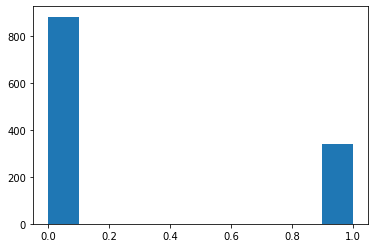

In [782]:
plt.hist(Y)

# Build train and validation set

In [793]:
img, _, x, y, z, l = list(np.array(X).shape)
X_train = np.array(X).reshape(img, x, y, z, l)
y_train = keras.utils.to_categorical(Y, 2)
x,y,z,l

# Build model

In [830]:
print("Build model")
model = Sequential()
input_layer = Input((x, y, z, l))

## convolutional layers
conv_layer1 = Conv3D(filters=18, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=18, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)
#pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)
#conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
#conv_layer4 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
#pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
#conv_layer5 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(pooling_layer2)
#conv_layer6 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer5)
#pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer6)
#conv_layer7 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu')(pooling_layer3)
#conv_layer8 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu')(conv_layer7)
#pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer8)
#pooling_layer1 = AveragePooling3D(pool_size=(2, 2, 2))(conv_layer2)
#pooling_layer1 = GlobalAveragePooling3D()(conv_layer2)
## add max pooling to obtain the most imformatic features
#pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
#conv_layer3 = Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu')(conv_layer2)
#conv_layer4 = Conv3D(filters=64, kernel_size=(2, 2, 2), activation='relu')(conv_layer3)
#pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
#pooling_layer4 = BatchNormalization()(conv_layer4)
average_layer = GlobalMaxPooling3D()(conv_layer2)
#flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer2 = Dropout(0.4)(average_layer)
output_layer = Dense(units=2,  activation='softmax')(dense_layer2)


## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
  optimizer=keras.optimizers.Adam(lr=1e-2),
  loss=keras.losses.BinaryCrossentropy())

class_weight = {0: 1,
                1: 884/399}


print("Fit model")
model.fit(x=X_train, y=y_train, batch_size=128, epochs=50, validation_split=0.2, workers=4, class_weight=class_weight)

Build model
Fit model
Train on 978 samples, validate on 245 samples
Epoch 1/50
978/978 [==============================] - 12s 12ms/step - loss: 0.9531 - val_loss: 0.9032
Epoch 2/50
978/978 [==============================] - 12s 12ms/step - loss: 0.9198 - val_loss: 0.8777
Epoch 3/50
978/978 [==============================] - 12s 12ms/step - loss: 0.9007 - val_loss: 0.8572
Epoch 4/50
978/978 [==============================] - 11s 12ms/step - loss: 0.8766 - val_loss: 0.8359
Epoch 5/50
978/978 [==============================] - 12s 12ms/step - loss: 0.8441 - val_loss: 0.8119
Epoch 6/50
978/978 [==============================] - 12s 12ms/step - loss: 0.8069 - val_loss: 0.8065
Epoch 7/50
978/978 [==============================] - 12s 12ms/step - loss: 0.7822 - val_loss: 0.7892
Epoch 8/50
978/978 [==============================] - 12s 12ms/step - loss: 0.7420 - val_loss: 0.8103
Epoch 9/50
978/978 [==============================] - 12s 12ms/step - loss: 0.7107 - val_loss: 0.7813
Epoch 10/50
97

KeyboardInterrupt: 

In [924]:
model.summary()

Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        (None, 20, 20, 20, 9)     0         
_________________________________________________________________
conv3d_142 (Conv3D)          (None, 18, 18, 18, 18)    4392      
_________________________________________________________________
conv3d_143 (Conv3D)          (None, 16, 16, 16, 18)    8766      
_________________________________________________________________
global_max_pooling3d_8 (Glob (None, 18)                0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 38        
Total params: 13,196
Trainable params: 13,196
Non-trainable params: 0
______________________________________________________

# Predict on training

In [832]:
model.evaluate(X_train, y_train)

1223/1223 [==============================] - 5s 4ms/step


0.22218850866654616

In [833]:
preds = model.predict(X_train)

[[0.8131832480430603, 0.1868167221546173],
 [0.016113167628645897, 0.9838867783546448],
 [0.9543275833129883, 0.04567248374223709],
 [0.5890776515007019, 0.41092240810394287],
 [0.7737770676612854, 0.2262229025363922],
 [0.8817489743232727, 0.11825104057788849],
 [0.25881800055503845, 0.7411819696426392],
 [0.901715874671936, 0.09828413277864456],
 [0.725142776966095, 0.27485722303390503],
 [0.05678728595376015, 0.9432127475738525],
 [0.88603276014328, 0.11396727710962296],
 [0.6424170732498169, 0.3575829565525055],
 [0.02973797544836998, 0.9702620506286621],
 [0.6745150089263916, 0.3254849910736084],
 [0.9830272793769836, 0.01697278395295143],
 [0.9571701884269714, 0.04282984882593155],
 [0.6293709874153137, 0.3706290125846863],
 [0.9086841940879822, 0.09131581336259842],
 [0.8560575246810913, 0.1439424604177475],
 [0.9793645739555359, 0.020635463297367096],
 [0.06776189059019089, 0.9322381615638733],
 [0.06136295944452286, 0.9386370778083801],
 [0.9697246551513672, 0.0302753113210201

(array([452., 222.,  94.,  50.,  39.,  31.,  23.,  45.,  68., 199.]),
 array([0.00260597, 0.10224485, 0.20188373, 0.3015226 , 0.4011615 ,
        0.5008004 , 0.60043925, 0.7000781 , 0.799717  , 0.8993559 ,
        0.99899477], dtype=float32),
 <a list of 10 Patch objects>)

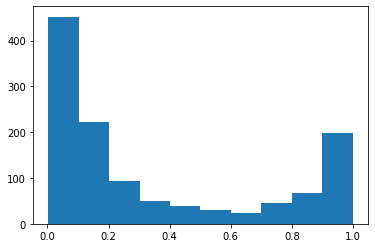

In [1134]:
plt.hist(preds[:,1])

In [1137]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(Y, [np.argmax(pred) for pred in preds])

array([[827,  57],
       [ 30, 309]])

# Sensitivity analysis

## All elements

In [ ]:
for pdb in pdbs:
    atoms = pd.parsePDB(pdb, model=i)
    

In [1204]:
ac1 = model.evaluate(X_train, y_train)

1223/1223 [==============================] - 5s 4ms/step


In [1205]:
vocabulary_elements

{'C': 0, 'O': 1, 'H': 2, 'Cl': 3, 'N': 4, 'F': 5, 'Br': 6, 'I': 7, 'S': 8}

In [1222]:
new_X_train =  X_train.copy()
channel = 8
for i, sample in enumerate(new_X_train):
    for r in range(x):
        for j in range(y):
            for k in range(l):
                if new_X_train[i][r,j,k, channel] != 0:
                    new_X_train[i][r,j,k, channel] = 0
                

In [1223]:
for i, sample in enumerate(new_X_train):
    for r in range(x):
        for j in range(y):
            for k in range(l):
                assert new_X_train[i][r,j,k, channel] == 0, (i,r,j,k)
                    

In [1224]:
ac2 = model.evaluate(new_X_train, y_train)

1223/1223 [==============================] - 5s 4ms/step


In [1225]:
importance = ac2-ac1
importance

5.763686297860504e-05

# CMAP

https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

Problem to visualize 3D data! Difficult to get a sense

In [1123]:
from keras import backend as K
nsample = 10
#Prediction
argmax = np.argmax(preds[nsample])
#Probability
probability = preds[nsample][argmax]
#Output
output = model.output[:, argmax]
#Las convulutional layer
last_conv_layer = model.get_layer('conv3d_143')
#Intensity of the channels
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2, 3))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([X_train])

In [1124]:
#For each channel we multiply for its intensity
for i in range(conv_layer_output_value.shape[2]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [1125]:
npixel = 20
heat_map_grids = []
heat_elements_grids = []
print( DATASER[nsample][1])
for plane in range(20):
    assert DATASER[439][1] == "structs-933.pdb"
    sample = X_train[nsample][:,:,plane].copy()
    explanation_grid = np.zeros((npixel, npixel)).copy()
    explanation_str_grid = np.empty((npixel, npixel), dtype="<U5")
    x, y, channels = sample.shape


    key_list = list(vocabulary_elements.keys()) 
    val_list = list(vocabulary_elements.values())

    for i in range(x):
        for j in range(y):
            for k in range(channels):
                channel = sample[i, j, k]
                if channel != 0:
                    element = key_list[val_list.index(k)]
                    explanation_grid[i, j] += 1
                    explanation_str_grid[i, j] += element
    heat_map_grids.append(explanation_grid)
    heat_elements_grids.append(explanation_str_grid)

structs-1065.pdb


In [1126]:
final_grid_elements = np.empty((npixel, npixel), dtype="<U5")
final_grid = np.zeros((npixel, npixel)).copy()
for grid_el, grid in zip(heat_elements_grids, heat_map_grids):
    final_grid_elements = np.core.defchararray.add(final_grid_elements, grid_el)
    final_grid += grid
    

In [1127]:
print(final_grid_elements)

[['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' 'H' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' 'H' '' '' '' 'HCH' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' 'H' 'CCCH' 'HH' 'CH' 'HC' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' 'H' 'H' 'C' '' 'H' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' 'HCCH' 'H' 'HHC' 'N' '' 'NH' '' '' '' '' '' '' '']
 ['' '' '' '' 'O' 'CH' 'CH' 'NO' 'C' '' 'H' 'HCC' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' 'CH' 'C' 'N' '' '' 'H' '' 'C' 'HH' '' '' '' '' '' '']
 ['' '' '' 'H' 'C' '' 'C' 'H' '' '' '' '' 'H' '' '' '' '' '' '' '']
 ['' '' '' '' 'C' 'C' '' '' '' '' '' '' '' '' '' '' '' '' '' '

Class 0 Prob 0.88603276


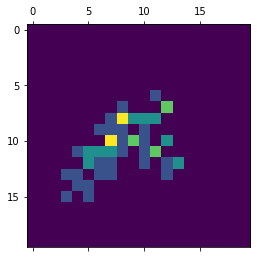

In [1128]:
print("Class", argmax, "Prob", probability)
data = final_grid
plt.matshow(data)
plt.show()

In [1129]:
output = np.zeros(conv_layer_output_value[:,:,1].shape)
for i in range(conv_layer_output_value.shape[2]):
    output += conv_layer_output_value[:,:,i]
output

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Predicted Class 0 Real Class 0 Prob 0.88603276 Sample structs-1065.pdb


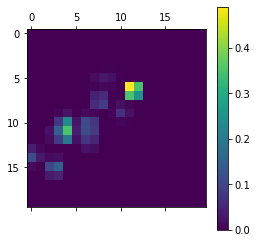

In [1139]:
import cv2
print("Predicted Class", argmax, "Real Class", Y[0], "Prob", probability, "Sample", DATASER[nsample][1])
heatmap = np.mean(output, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (20, 20))
plt.matshow(heatmap)
plt.colorbar()
plt.show()



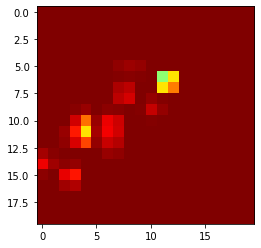

In [1131]:
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
data = np.uint8(255 * data)
data = cv2.applyColorMap(data, cv2.COLORMAP_BONE)
hif = 0.8
superimposed_img = heatmap * hif + data
plt.imshow(heatmap)

In [496]:
print(np.array(DATASER)[:,1][439])
print(vocabulary_elements)
np.array(DATASER)[:,0][439][0][:,:,:,3].tolist()

structs-933.pdb
{'C': 0, 'O': 1, 'H': 2, 'Cl': 3, 'N': 4, 'F': 5, 'Br': 6, 'I': 7, 'S': 8}


[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0

In [359]:
for plane in range(9):
    for i in range(15):
        sample = X_train[nsample][:,:,plane].copy()
        explanation_grid = np.empty((15, 15), dtype=str)
        x, y, channels = sample.shape


        key_list = list(vocabulary_elements.keys()) 
        val_list = list(vocabulary_elements.values())

        for i in range(x):
            for j in range(y):
                for k in range(channels):
                    channel = sample[i, j, k]
                    if channel != 0:
                        element = key_list[val_list.index(k)]
                        explanation_grid[i, j] += element
    print("Plane {}".format(plane))
    print(explanation_grid)

               


Plane 0
[['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]
Plane 1
[['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' 

In [269]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(32, 2)

In [296]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))

In [297]:
cam_model.summary()

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 15, 15, 15, 9)     0         
_________________________________________________________________
conv3d_78 (Conv3D)           (None, 13, 13, 13, 16)    3904      
_________________________________________________________________
conv3d_79 (Conv3D)           (None, 11, 11, 11, 32)    13856     
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 5, 5, 5, 32)       0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 5, 5, 5, 32)       128       
_________________________________________________________________
flatten_17 (Flatten)         (None, 4000)              0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 4000)              0  

In [283]:
features,results = cam_model.predict(X_train)
features.shape, results.shape

((1223, 11, 11, 11, 32), (1223, 2))

In [284]:
results

array([[0.71341306, 0.286587  ],
       [0.70353806, 0.29646197],
       [0.72362846, 0.27637154],
       ...,
       [0.72155726, 0.27844274],
       [0.71080273, 0.28919727],
       [0.7032597 , 0.29674023]], dtype=float32)

In [285]:
for i, result in enumerate(results):
    if np.argmax(result) == 1:
        print(i)

In [252]:
for idx in range(2):
    features_for_one_img = features[idx,:,:,:]
    #height_roomout = X_train.shape[1]/features_for_one_img.shape[0]
    #width_roomout  = X_train.shape[2]/features_for_one_img.shape[1]
    #print(height_roomout,width_roomout)
 
    #cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    #print(cam_features.shape)
    pred = np.argmax(results[idx])
    cam_features = features_for_one_img
    
    
    plt.figure(facecolor='white')
    cam_weights = gap_weights[:,pred]
    cam_output  = np.dot(cam_features,cam_weights)
    #print(features_for_one_img.shape)

    buf = 'Predicted Class = ' +str( pred )+ ', Probability = ' + str(results[idx][pred])

    

    #plt.imshow(np.squeeze(X_train[idx],-1), alpha=0.5)

    for i in range(6):
        plt.figure(facecolor='white')
        new_buf  = buf + "plane {}".format(i)
        plt.xlabel(new_buf)
        plt.imshow(cam_output[:,:,i], cmap='jet', alpha=0.5)


ValueError: shapes (11,11,11,32) and (4000,) not aligned: 32 (dim 3) != 4000 (dim 0)

<Figure size 432x288 with 0 Axes>

In [151]:
print(explanation_grid)

[['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' 'O' '' '' '' '' '' '']
 ['' '' '' '' '' '' 'O' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' 'O' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]


In [116]:
sample

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [112]:
vocabulary_elements

{'C': 0, 'O': 1, 'H': 2, 'Cl': 3, 'N': 4, 'F': 5, 'Br': 6, 'I': 7, 'S': 8}